## Import everything that we need here

In [14]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [15]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Using cuda
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

print(use_cuda)
print(device)

True
cuda


## Defining the NN

In [17]:
def init_weights(m):
    # print(f"This is m : {m}")
    # print(f"This is the type of m : {type(m)}")
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

class ActorCritic(nn.Module):
    def __init__(
            self,
            num_inputs,
            num_outputs,
            hidden_size,
            std=0.0
    ):
        super(ActorCritic, self).__init__()

        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )

        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)

        self.apply(init_weights)

    def forward(
            self,
            x
    ):
        value = self.critic(x)
        mu = self.actor(x)
        std = self.log_std.exp().expand_as(mu)
        dist = Normal(mu, std)
        return dist, value

In [18]:
def collect_experience(
    envs,
    model,
    num_steps
):
    pass

    frames = []
    rewards = []
    actions = []
    values  = []
    masks = []
    states = []
    log_probs = []
    entropy = 0

    state, info = envs.reset()

    for step in range(num_steps):
        
        if len(state.shape) == 1:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
        else:
            state = torch.FloatTensor(state).to(device)
            
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _, _ = envs.step(action.cpu().numpy()) #if you pass in action.cpy().numpy()[0] we will get a scalar value or single value tuple (3,)

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        states.append(state)
        actions.append(action)
        
        state = next_state

        #print('-' * 50)
        #print(f"Step : {step}")
        #print(f"Current State : {state}")
        #print(f"Currrent Action : {action}")
        #print(f"Next State : {next_state}")
        
        # The interesting part is how the reward is calculated
        # reward is -(angle_cost + velocity_cost + action_cost)

        # angle_cost = angle**2                      Penalty for being away from upright (0°)
        # velocity_cost = 0.1 * angular_velocity**2  Penalty for moving too fast
        # action_cost = 0.001 * action**2            Penalty for using large torques
        #print(f"Reward : {reward}")
        
        #frame = env.render()
        #frames.append(frame)
    
    return (
        frames,
        rewards,
        actions,
        values,
        masks,
        states,
        log_probs,
        entropy,
        next_state
    )



In [19]:
# Generalized advtange exstimate is the total advantage that is expected at any particular time. Advtange is the reward that will be used to train the RL network
def compute_gae(next_value, 
            rewards,
            values, 
            masks,
            gamma=0.9, 
            tau=0.95
        ):
    
    values = values + [next_value]
    gae = 0
    returns = []
    
    for step in reversed(range(len(rewards))):

        gae = rewards[step] + masks[step] *gamma * (tau * gae + (1 - tau) * values[step + 1])

        returns.insert(0, gae)
    
    return returns

## The real training 

In [20]:
def ppo_randomizer(
    mini_batch_size,
    states,
    actions,
    log_probs,
    returns,
    advantages
) :

    batch_size = states.size(0)

    for _ in range(batch_size // mini_batch_size):
        rand_indexes = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_indexes], actions[rand_indexes], log_probs[rand_indexes], returns[rand_indexes], advantages[rand_indexes]

def ppo_trainer(
    model,
    optimizer,
    ppo_epochs,
    mini_batch_size,
    states,
    actions,
    log_probs,
    returns,
    advantages,
    clip_param = 0.2
):

    batch_loss = []
    batch_actor_loss = []
    batch_critic_loss = []

    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_vals, advantage in ppo_randomizer(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state) # Action space and value chosen by the new policy
            entropy = dist.entropy().mean() #what is the entropy of my new policy distribution
            new_log_probs = dist.log_prob(action) #what is the likelihood that my new policy is to take the old action?

            ratio = (new_log_probs - old_log_probs).exp()

            surrogate_unclipped = ratio * advantage
            surrogate_clipped = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage
            
            actor_loss = -torch.min(surrogate_unclipped,surrogate_clipped).mean()
            critic_loss = (return_vals - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001* entropy

            optimizer.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

            batch_actor_loss.append(actor_loss.item())
            batch_critic_loss.append(critic_loss.item())
            batch_loss.append(loss.item())
    
    return (
        np.mean(batch_loss),
        np.mean(batch_actor_loss),
        np.mean(batch_critic_loss)
    )


In [21]:
def check_model_stats(model, iteration):

    all_params = []

    for param in model.parameters():
        all_params.append(param.data.flatten())
    
    all_params = torch.cat(all_params)

    stats = {
        'iteration': iteration,
        'total_params': all_params.numel(),
        'mean': all_params.mean().item(),
        'std': all_params.std().item(),
        'min': all_params.min().item(),
        'max': all_params.max().item(),
        'norm': all_params.norm().item()
    }
    
    return stats

In [22]:
import gymnasium as gym
from gymnasium.vector import SyncVectorEnv
from tqdm import tqdm

num_envs = 5
env_name = "Pendulum-v1"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env 
    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SyncVectorEnv(envs)

env = gym.make(env_name, render_mode="rgb_array")

num_inputs  = envs.single_observation_space.shape[0]
num_outputs = envs.single_action_space.shape[0]

#Hyper params:

hidden_size      = 512
lr               = 2e-4
num_steps        = 125
mini_batch_size  = 25
ppo_epochs       = 4
threshold_reward = -200

learning_iterations = 1000

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

def train_the_model(
    envs,
    model,
    num_learning_iterations
):

    episodic_rewards = []
    episodic_losses = []
    episodic_actor_losses = []
    episodic_critic_losses = []

    for it in tqdm(range(num_learning_iterations), desc="Learning Iterations"):
        #print(f"learning iteration : {it}")

        frames, rewards, actions, values, masks, states, log_probs, entropy, next_state = collect_experience(
            envs=envs,
            model=model,
            num_steps=num_steps
        )

        single_episode_reward = sum(rewards)
        averaged_across_iterations = single_episode_reward.mean()
        episodic_rewards.append(averaged_across_iterations)
        
        if len(next_state.shape) == 1:
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        else:
            next_state = torch.FloatTensor(next_state).to(device)

        _, next_value = model(next_state)

        returns = compute_gae(next_value, rewards, values, masks)
        
        returns = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs).detach()
        values = torch.cat(values).detach()
        states = torch.cat(states)
        actions = torch.cat(actions)
        advantage = returns - values

        loss, actor_loss, critic_loss = ppo_trainer(
            model=model,
            optimizer=optimizer,
            ppo_epochs=ppo_epochs,
            mini_batch_size=mini_batch_size,
            states=states,
            actions=actions,
            log_probs=log_probs,
            returns=returns,
            advantages=advantage
        )

        episodic_losses.append(loss)
        episodic_actor_losses.append(actor_loss)
        episodic_critic_losses.append(critic_loss)

    return episodic_rewards, episodic_losses, episodic_actor_losses, episodic_critic_losses



print(check_model_stats(model=model, iteration=0))

rewards, losses, actor_losses, critic_losses = train_the_model(
    envs=envs,
    model=model,
    num_learning_iterations=learning_iterations
)

{'iteration': 0, 'total_params': 5123, 'mean': 0.01931048184633255, 'std': 0.09704625606536865, 'min': -0.33212992548942566, 'max': 0.4239047169685364, 'norm': 7.081610679626465}


Learning Iterations: 100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]


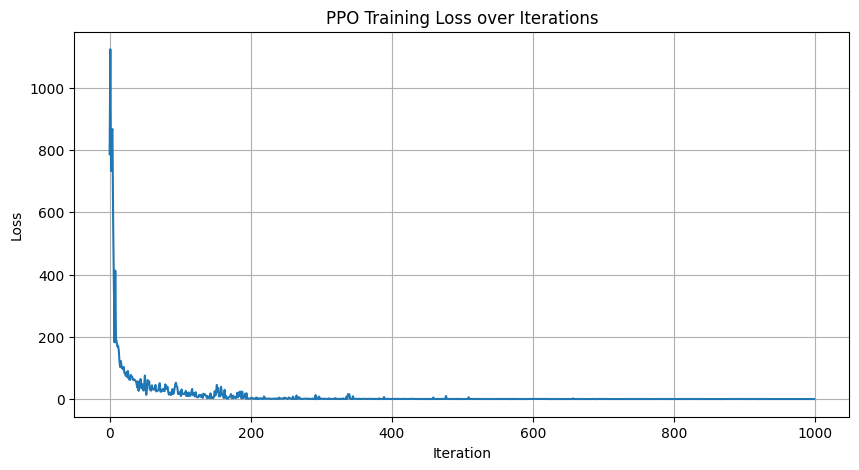

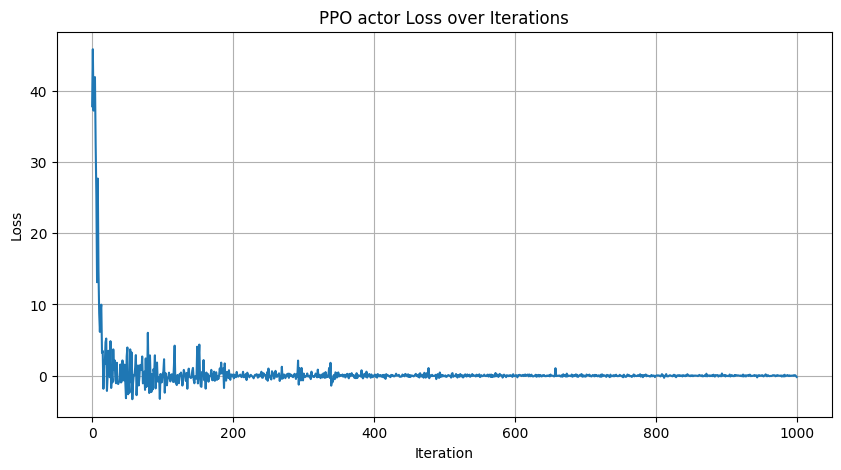

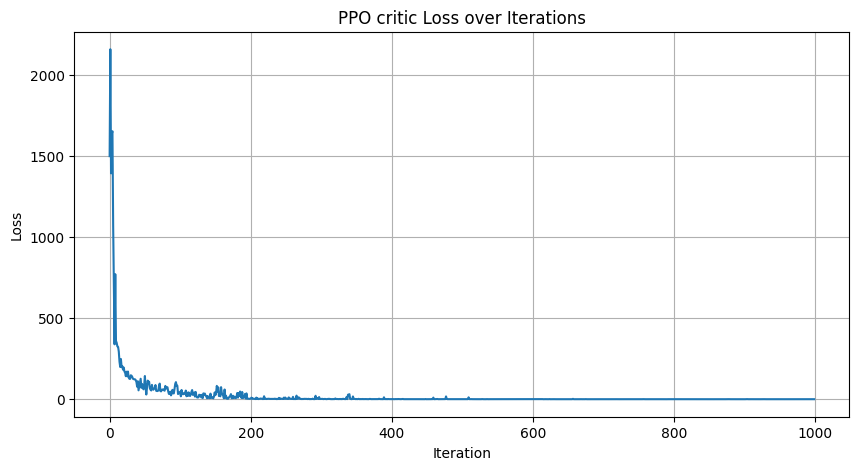

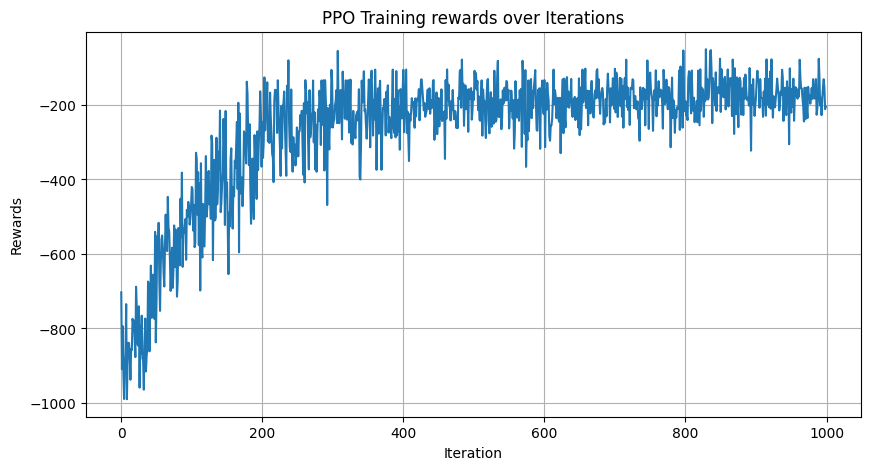

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('PPO Training Loss over Iterations')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(actor_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('PPO actor Loss over Iterations')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(critic_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('PPO critic Loss over Iterations')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 5))
plt.plot([r.cpu() for r in rewards])
plt.xlabel('Iteration')
plt.ylabel('Rewards')
plt.title('PPO Training rewards over Iterations')
plt.grid(True)
plt.show()